In [97]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


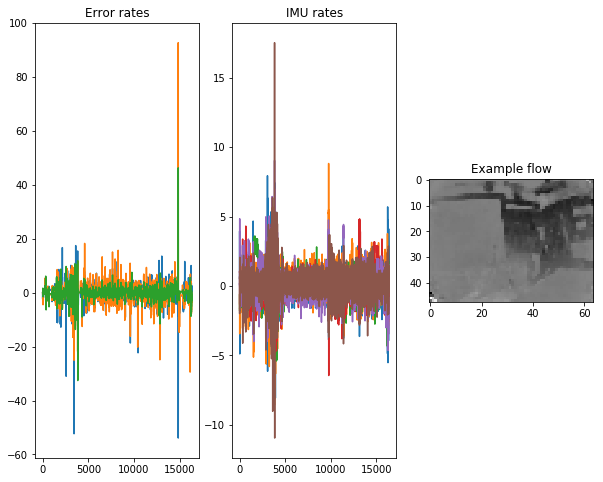

In [140]:
# Import data without time stamps
y_data = (np.genfromtxt('errors.csv', delimiter=',')[:,1:4]).astype(np.float32)
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[:,1:7]).astype(np.float32)
# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)

#flows_data = np.load('/media/Big_Data/stefantj/flows1.npy') # note: this only loads 1k flows, the whole flow file is huge!
flows_data = np.load('/media/Big_Data/stefantj/flows_lowres.npy') # Currently has 2k images, downsampled to 64x48.
# Normalize image data
flows_data -= flows_data.mean(axis=0)
flows_data /= np.std(flows_data,axis=0)

plt.subplot(1,3,1)
plt.title('Error rates')
plt.plot(y_data)
plt.subplot(1,3,2)
plt.title('IMU rates')
plt.plot(imu_data)
plt.subplot(1,3,3)
plt.title('Example flow')
plt.imshow(flows_data[np.random.randint(0,flows_data.shape[0]),:,:,1])

# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
def sample_minibatch(sequence_length, iseq=None):
    x_imu_batch = np.zeros((sequence_length, imu_data.shape[1]))
    x_img_batch = np.zeros((sequence_length, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    y_batch = np.zeros((sequence_length, y_data.shape[1]))
    
    if(iseq is None):
        # randomly sample endpoint:
        i_stop = np.random.randint(sequence_length, 700) 
    else:
        i_stop = iseq
    x_imu_batch = imu_data[i_stop-sequence_length:i_stop,:]
    y_batch = y_data[i_stop-sequence_length:i_stop,:]
    x_img_batch = flows_data[i_stop-sequence_length:i_stop,:,:,:]
    return x_imu_batch, x_img_batch, y_batch

def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [141]:
# Definition of network:
# rescale the images ~ 64x48
# Try normalizing 
# feed output back in
# see if you can get cats roughly hte same size

OUTPUT_DIM = 3
BATCH_SIZE = 4
R_HISTORY = 10
IMG_H = 48
IMG_W = 64
class tangoNet(object):

    # Extract features for a single time step
    def extract_features(self, input_img=None, input_imu=None, reuse=True):
        if input_img is None:
            input_img = self.image  # will need to split this into input1, input2
        if input_imu is None:
            input_imu = self.imu
        x = input_img
        x_r = input_imu
        
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('cnn_1'):
                # 64 filters of size 5 <- needs to be tuned!
                x = tf.layers.conv2d(x, 16, 3, strides=2, activation=tf.nn.relu, padding='valid')
                layers.append(x)     
            with tf.variable_scope('cnn_2'):
                x = tf.nn.max_pool(x, [1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('dense_1'):
                x_r = tf.layers.dense(x_r, 32, activation=tf.nn.relu)
                layers.append(x_r)
            with tf.variable_scope('concat1'):
                # reshape: 
                x = tf.reshape(x, [BATCH_SIZE,-1])
                x_r = tf.reshape(x_r, [BATCH_SIZE,-1])
                x = tf.concat([x,x_r],1)
                layers.append(x)
            return layers

    def __init__(self, batch_size, save_path=None, sess=None):
        self.batch_size = tf.constant(batch_size,dtype=tf.int32)
        # r_depth, batch, width, height, channels
        self.image = tf.placeholder('float',shape=[R_HISTORY*batch_size,IMG_H,IMG_W,2],name='input_image_seq')
        # r_depth, batch, input_dim
        self.imu   = tf.placeholder('float',shape=[R_HISTORY*batch_size,6],name='input_imu_seq')
        # batch, output_dim
        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size, OUTPUT_DIM],name='output_error')

        self.layers = []
        self.features = []
        for k in range(R_HISTORY):
            img = self.image[batch_size*k:batch_size*(k+1),:,:,:]
            imu = self.imu[batch_size*k:batch_size*(k+1),:]
            r = (k!=0)
            self.features.append(self.extract_features(img, imu, reuse=r)[-1])
        
        with tf.variable_scope('core_lstm'):
            with tf.variable_scope('core_0'):
                x_r = self.features
                self.layers.append(x_r)
            with tf.variable_scope('core_1'):
                lstm_cell = tf.contrib.rnn.BasicLSTMCell(128)
                x_r, states = tf.contrib.rnn.static_rnn(lstm_cell, x_r, dtype=tf.float32)
                self.layers.append(x_r[-1])
            with tf.variable_scope('core_2'):
                W = tf.get_variable("weights", shape=[128,OUTPUT_DIM])
                b = tf.get_variable("bias", shape=[OUTPUT_DIM])
                x_r = tf.concat(x_r, axis=0)
                x_r = tf.matmul(x_r, W) + b
                self.layers.append(x_r)
        self.prediction = tf.reshape(x_r, [-1, OUTPUT_DIM])


        if save_path is not None:
            saver = tf.train.Saver()
            saver.restore(sess, save_path)
        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs, self.prediction)))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(self.rmse)


Step:  10  MSE:  0.682901  Val:  0.581998


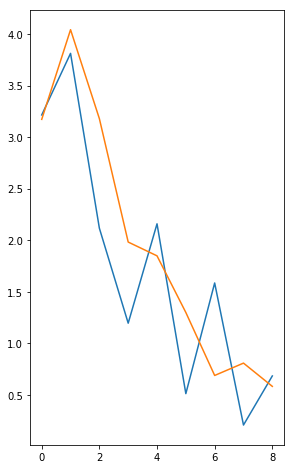

Step:  20  MSE:  0.538141  Val:  1.78145


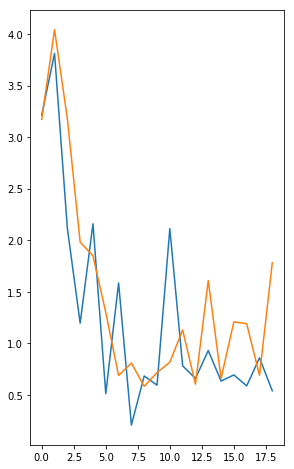

Step:  30  MSE:  0.714999  Val:  0.837997


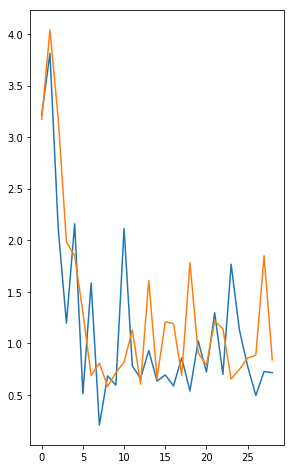

Step:  40  MSE:  0.859341  Val:  0.352675


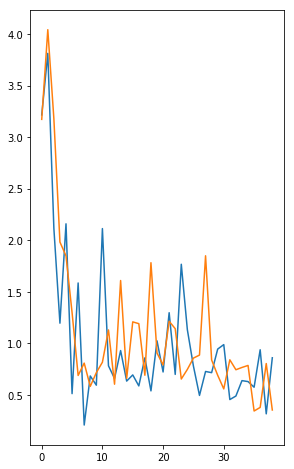

Step:  50  MSE:  0.500798  Val:  0.120786


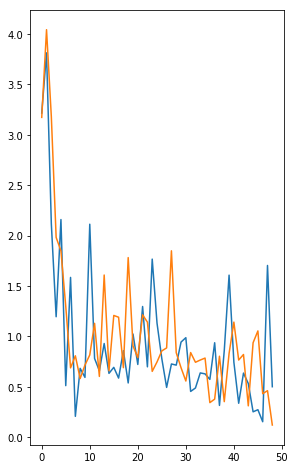

Step:  60  MSE:  0.781397  Val:  0.866988


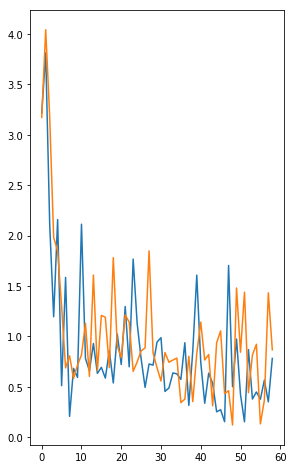

Step:  70  MSE:  0.665814  Val:  1.65385


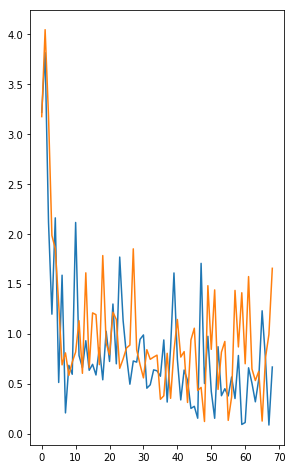

Step:  80  MSE:  0.159372  Val:  0.984628


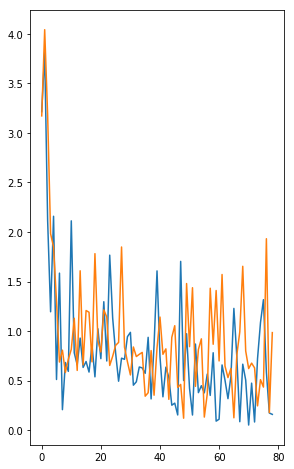

Step:  90  MSE:  0.725846  Val:  1.53572


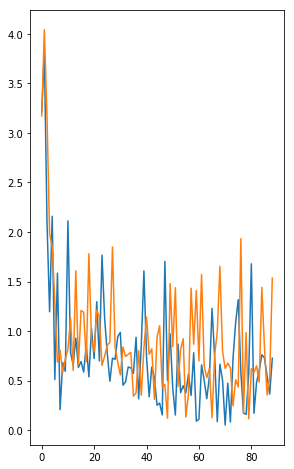

Step:  100  MSE:  1.53973  Val:  0.157502


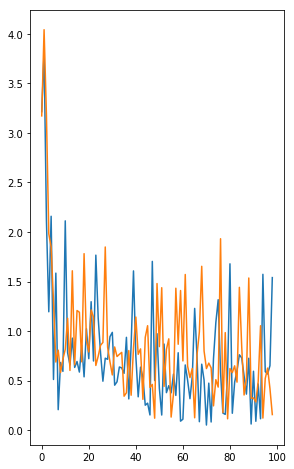

Step:  110  MSE:  1.11178  Val:  0.562483


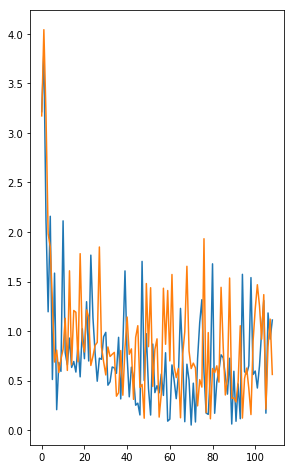

Step:  120  MSE:  0.496688  Val:  0.698886


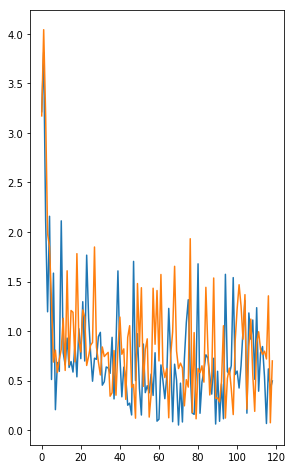

Step:  130  MSE:  0.136121  Val:  0.44123


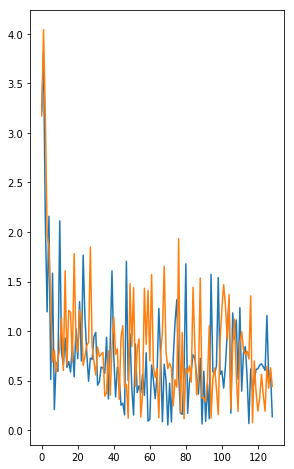

Step:  140  MSE:  0.714441  Val:  0.758884


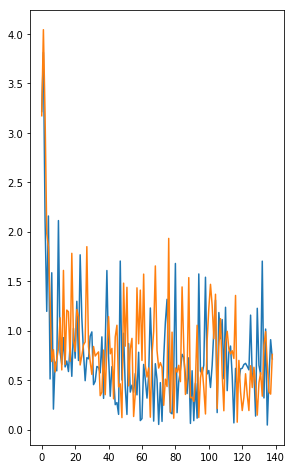

Step:  150  MSE:  0.115356  Val:  0.359155


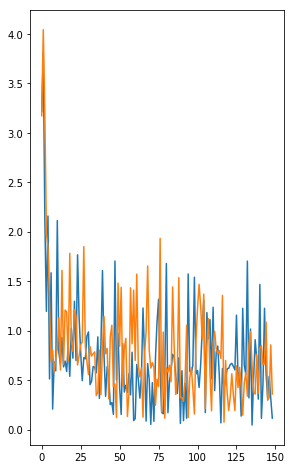

Step:  160  MSE:  0.599237  Val:  1.01028


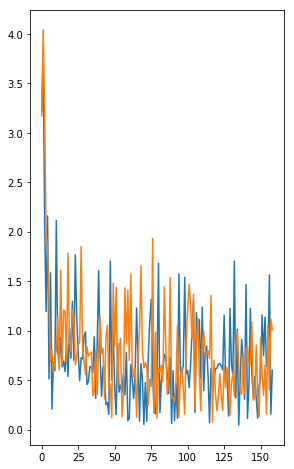

Step:  170  MSE:  0.0432729  Val:  0.529694


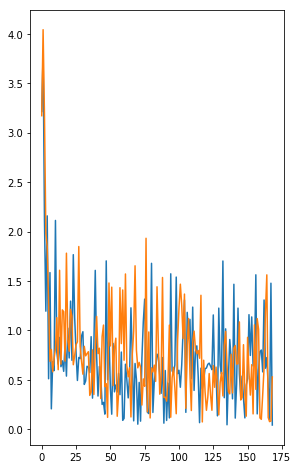

Step:  180  MSE:  0.487682  Val:  0.136023


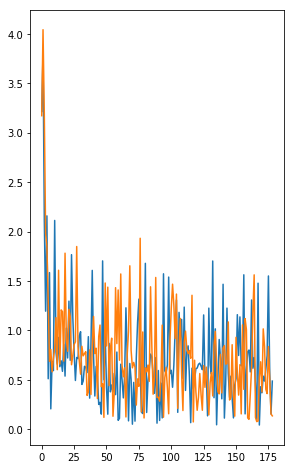

Step:  190  MSE:  0.776265  Val:  0.570964


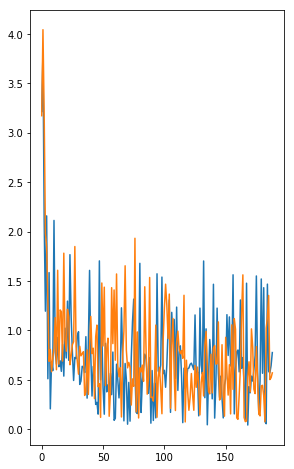

Step:  200  MSE:  0.150729  Val:  0.73918


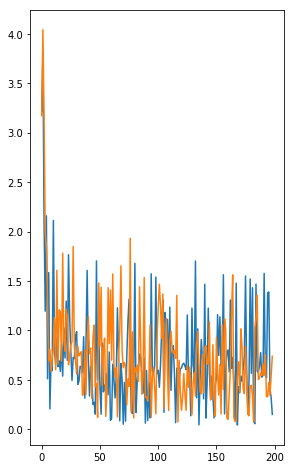

Computing sequence prediction - this may take a while. 
k =  100
k =  200
k =  300
k =  400
k =  500
k =  600
k =  700
k =  800
k =  900
k =  1000
k =  1100
k =  1200
k =  1300
k =  1400
k =  1500
k =  1600
k =  1700
k =  1800
k =  1900


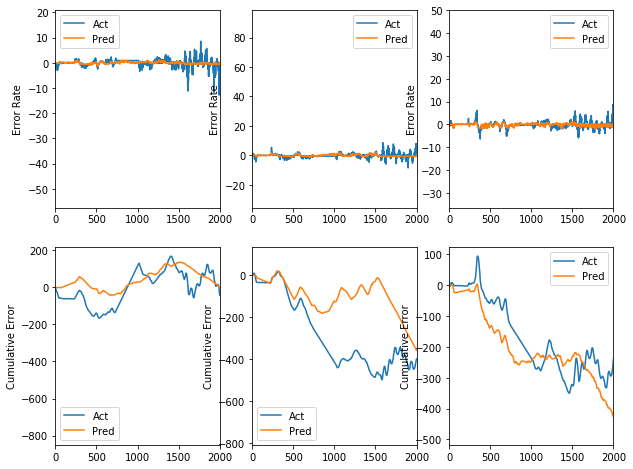

In [142]:
# simple parameters:
disp_period = 10
training_iters = 200

with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = '/media/Big_Data/stefantj/tangonet.ckpt'

    model = tangoNet(batch_size = BATCH_SIZE, sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []

    # Launch the graph
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step  < training_iters:
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x1, batch_x2, batch_y = sample_minibatch(R_HISTORY*BATCH_SIZE)

        # Run optimization op (backprop)
        sess.run(model.optimizer, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        # Calculate batch accuracy
        mse = sess.run(model.rmse, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        train_history.append(mse)
        # Calculate val accuracy:
        batch_x1, batch_x2, batch_y = sample_minibatch(R_HISTORY*BATCH_SIZE)
        vmse = sess.run(model.rmse, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        val_history.append(vmse)
        step += 1
        if step % disp_period is 0:
            print('Step: ', step, ' MSE: ', mse, ' Val: ', vmse)
            plt.subplot(1,2,1)
            plt.plot(train_history)
            plt.plot(val_history)
            plt.show()
    # Compute sequence prediction:
    print('Computing sequence prediction - this may take a while. ')
    y_pred = np.zeros_like(y_data)
    for k in range(BATCH_SIZE*R_HISTORY, flows_data.shape[0]):
        if k % 100 is 0:
            print('k = ', k)
        batch_x1, batch_x2, batch_y = sample_minibatch(R_HISTORY*BATCH_SIZE, k)
        pred = sess.run(model.prediction, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        y_pred[k,:] = pred[-1,:]

    for k in range(3):
        plt.subplot(2,3,k+1)
        plt.ylabel('Error Rate')
        plt.plot(y_data[:,k])
        plt.plot(y_pred[:,k])
        plt.legend(['Act','Pred'])
        plt.xlim([0,flows_data.shape[0]])
                
        plt.subplot(2,3,k+4)
        plt.ylabel('Cumulative Error')
        plt.plot(np.cumsum(y_data[:,k]))
        plt.plot(np.cumsum(y_pred[:,k]))
        plt.legend(['Act','Pred'])
        plt.xlim([0,flows_data.shape[0]])

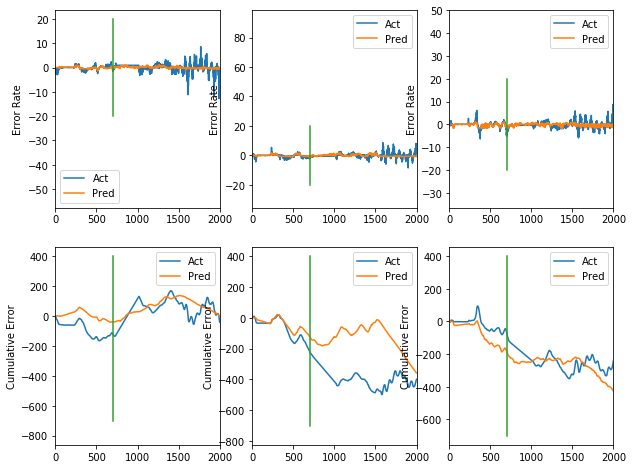

In [143]:
    for k in range(3):
        plt.subplot(2,3,k+1)
        plt.ylabel('Error Rate')
        plt.plot(y_data[:,k])
        plt.plot(y_pred[:,k])
        plt.plot([700,700],[-20,20])
        plt.legend(['Act','Pred'])
        plt.xlim([0,flows_data.shape[0]])
                
        plt.subplot(2,3,k+4)
        plt.ylabel('Cumulative Error')
        plt.plot(np.cumsum(y_data[:,k]))
        plt.plot(np.cumsum(y_pred[:,k]))
        plt.plot([700,700],[-700,400])
        plt.legend(['Act','Pred'])
        plt.xlim([0,flows_data.shape[0]])

-0.68827301